<a href="https://colab.research.google.com/github/nnaemekaukpa/Leveraging-Deep-Learning-Architecture-for-Accurate-and-Efficient-Bone-Cancer-Detection-/blob/main/VGG_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
## Allows loading of operating system
import os
## Allows loading of image dataset
import cv2
## For plotting
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import image as mpimg
## For array list
import numpy as np
## Allows selection of any images
import random
## Helps in resizing of images
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import shutil

from sklearn.metrics import roc_auc_score, roc_curve

import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_dataset = '/content/drive/MyDrive/bone cancer detection.v2i.folder/train'
valid_dataset = '/content/drive/MyDrive/bone cancer detection.v2i.folder/valid'
test_dataset = '/content/drive/MyDrive/bone cancer detection.v2i.folder/test'

In [ ]:
## fucntion to list files and folder in the directory
def list_contents(directory):
  if os.path.exists(directory):
    print(f'contents of {directory}:')
    print(os.listdir(directory))
  else:
    print(f'{directory} does not exist')



In [ ]:
list_contents(train_dataset)
list_contents(valid_dataset)
list_contents(test_dataset)

contents of /content/drive/MyDrive/bone cancer detection.v2i.folder/train:
['normal', 'cancer']
contents of /content/drive/MyDrive/bone cancer detection.v2i.folder/valid:
['cancer', 'normal']
contents of /content/drive/MyDrive/bone cancer detection.v2i.folder/test:
['cancer', 'normal']


In [ ]:
def count_files(directory):
  if os.path.exists(directory):
    classes=[i for i in os.listdir(directory) if os.path.isdir(os.path.join(directory, i))]
    total_files=sum([len(files) for _,_,files in os.walk(directory)])
    print(f'found {total_files} images belonging to {len(classes)} classes.')
  else:
    print(f'{directory} does not exist')

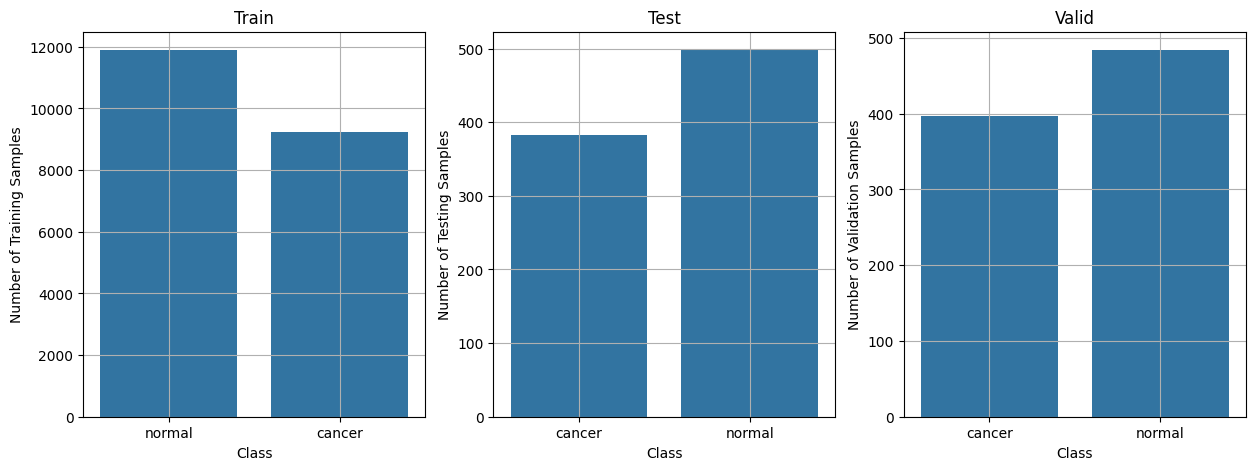

In [ ]:
import pandas as pd
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df


# Load data into DataFrames
train_dataset = data(train_dataset)  # Call the data function to load data
test_dataset = data(test_dataset)   # Call the data function to load data
valid_dataset = data(valid_dataset)  # Call the data function to load data

# Plotting class distribution
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.countplot(x=train_dataset.label)  # Now access the 'label' column of the DataFrame
plt.xlabel("Class")
plt.ylabel("Number of Training Samples")
plt.title('Train')
plt.grid(True)
plt.subplot(1, 3, 2)
sns.countplot(x=test_dataset.label)  # Now access the 'label' column of the DataFrame
plt.xlabel("Class")
plt.ylabel("Number of Testing Samples")
plt.title('Test')
plt.grid(True)
plt.subplot(1, 3, 3)
sns.countplot(x=valid_dataset.label)  # Now access the 'label' column of the DataFrame
plt.xlabel("Class")
plt.ylabel("Number of Validation Samples")
plt.title('Valid')
plt.grid(True)
plt.show()

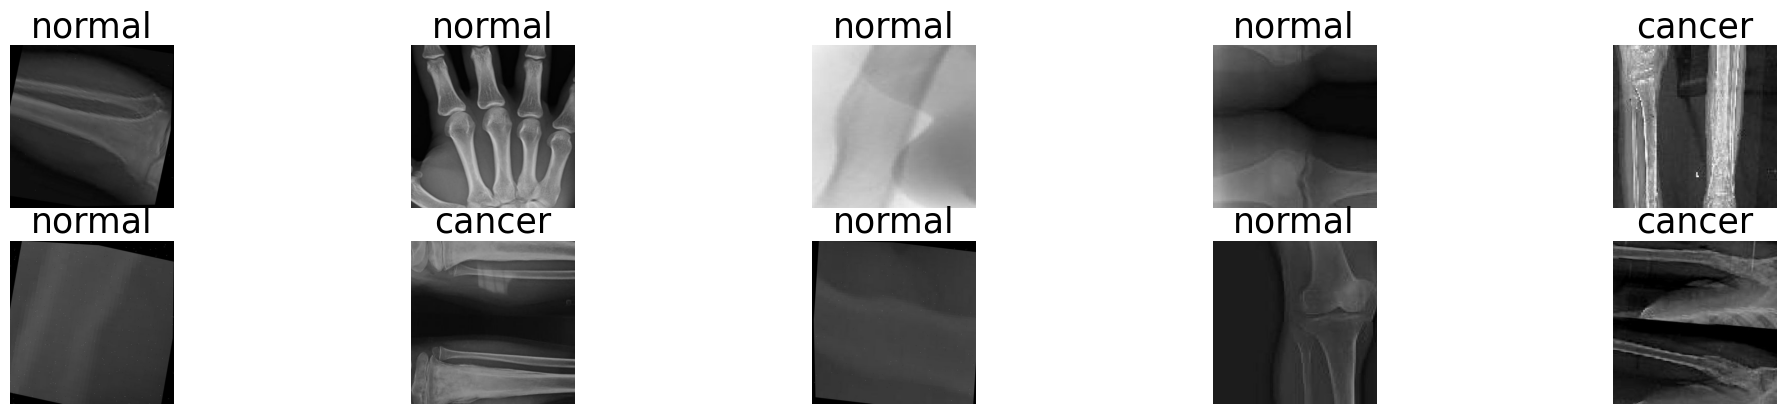

In [ ]:
# Display some sample images
plt.figure(figsize=(25, 25))
for n, i in enumerate(np.random.randint(0, len(train_dataset), 10)):
    plt.subplot(10, 5, n + 1)
    img = cv2.imread(train_dataset.image[i])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(train_dataset.label[i], fontsize=25)

In [ ]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train_dataset,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test_dataset,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
valid_generator = datagen.flow_from_dataframe(
    valid_dataset,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 21141 validated image filenames belonging to 2 classes.
Found 881 validated image filenames belonging to 2 classes.
Found 881 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [ ]:
# Load the pre-trained VGG19 model without the top layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers to retain pre-trained weights
base_model.trainable = False

# Add custom classification head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

# Display model summary
model.summary()

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 26,480,193 (101.01 MB)

 Trainable params: 6,455,809 (24.63 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=valid_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_steps=valid_generator.samples // batch_size
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 4231s 6s/step - accuracy: 0.6954 - auc: 0.7479 - loss: 0.5930 - val_accuracy: 0.8299 - val_auc: 0.9115 - val_loss: 0.3743
Epoch 2/10
  1/660 ━━━━━━━━━━━━━━━━━━━━ 1:00:27 6s/step - accuracy: 0.8125 - auc: 0.9176 - loss: 0.3916

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


660/660 ━━━━━━━━━━━━━━━━━━━━ 159s 233ms/step - accuracy: 0.8125 - auc: 0.9176 - loss: 0.3916 - val_accuracy: 0.8206 - val_auc: 0.9071 - val_loss: 0.3828
Epoch 3/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 3900s 6s/step - accuracy: 0.8033 - auc: 0.8825 - loss: 0.4259 - val_accuracy: 0.8403 - val_auc: 0.9292 - val_loss: 0.3439
Epoch 4/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 158s 232ms/step - accuracy: 0.8438 - auc: 0.9264 - loss: 0.3573 - val_accuracy: 0.8403 - val_auc: 0.9297 - val_loss: 0.3438
Epoch 5/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 3923s 6s/step - accuracy: 0.8132 - auc: 0.9013 - loss: 0.3933 - val_accuracy: 0.8634 - val_auc: 0.9354 - val_loss: 0.3197
Epoch 6/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 202s 299ms/step - accuracy: 0.7812 - auc: 0.8906 - loss: 0.4183 - val_accuracy: 0.8576 - val_auc: 0.9335 - val_loss: 0.3251
Epoch 7/10
660/660 ━━━━━━━━━━━━━━━━━━━━ 3921s 6s/step - accuracy: 0.8205 - auc: 0.9111 - loss: 0.3721 - val_accuracy: 0.8287 - val_auc: 0.9427 - val_loss: 0.3318
Epoch 8/10
660/660 ━━━━━━━━━━━━━━

In [ ]:
hist_=pd.DataFrame(history.history)
hist_

,accuracy,auc,loss,val_accuracy,val_auc,val_loss
0,0.749633,0.819701,0.516153,0.829861,0.911492,0.374275
1,0.812500,0.917647,0.391599,0.820602,0.907061,0.382787
2,0.802549,0.884294,0.422874,0.840278,0.929203,0.343936
3,0.843750,0.926407,0.357326,0.840278,0.929741,0.343846
4,0.816903,0.903067,0.388724,0.863426,0.935395,0.319663
5,0.781250,0.890625,0.418257,0.857639,0.933479,0.325104
6,0.822398,0.911768,0.370322,0.828704,0.942729,0.331751
7,0.812500,0.925101,0.326160,0.841435,0.946008,0.316366
8,0.828699,0.917528,0.356211,0.850694,0.950124,0.300241
9,0.843750,0.956863,0.280034,0.854167,0.949805,0.298130


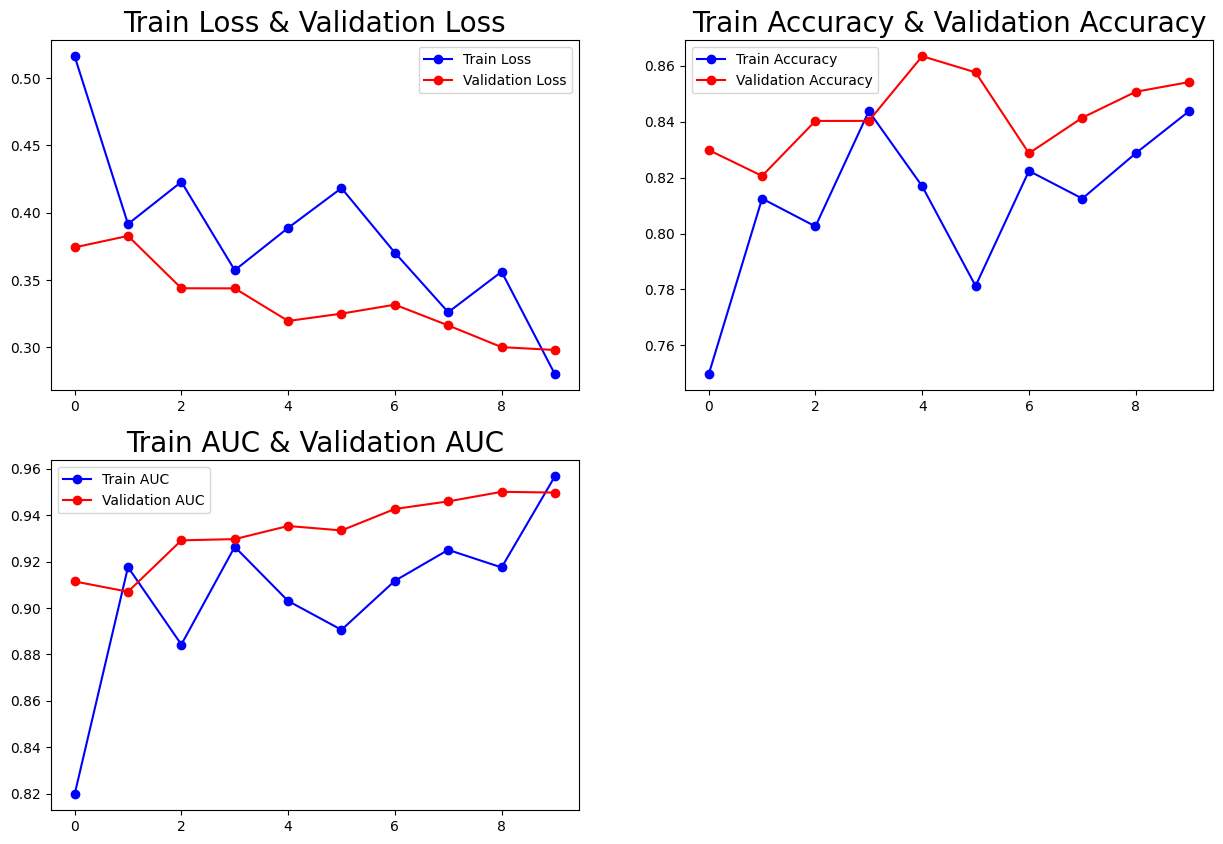

In [ ]:

# Training History Visualization
hist_ = history.history
plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(hist_['loss'], 'b-o', label='Train Loss')
plt.plot(hist_['val_loss'], 'r-o', label='Validation Loss')
plt.title('Train Loss & Validation Loss', fontsize=20)
plt.legend()
plt.subplot(2, 2, 2)
plt.plot(hist_['accuracy'], 'b-o', label='Train Accuracy')
plt.plot(hist_['val_accuracy'], 'r-o', label='Validation Accuracy')
plt.title('Train Accuracy & Validation Accuracy', fontsize=20)
plt.legend()
plt.subplot(2, 2, 3)
plt.plot(hist_['auc'], 'b-o', label='Train AUC')
plt.plot(hist_['val_auc'], 'r-o', label='Validation AUC')
plt.title('Train AUC & Validation AUC', fontsize=20)
plt.legend()
plt.show()

28/28 ━━━━━━━━━━━━━━━━━━━━ 157s 6s/step


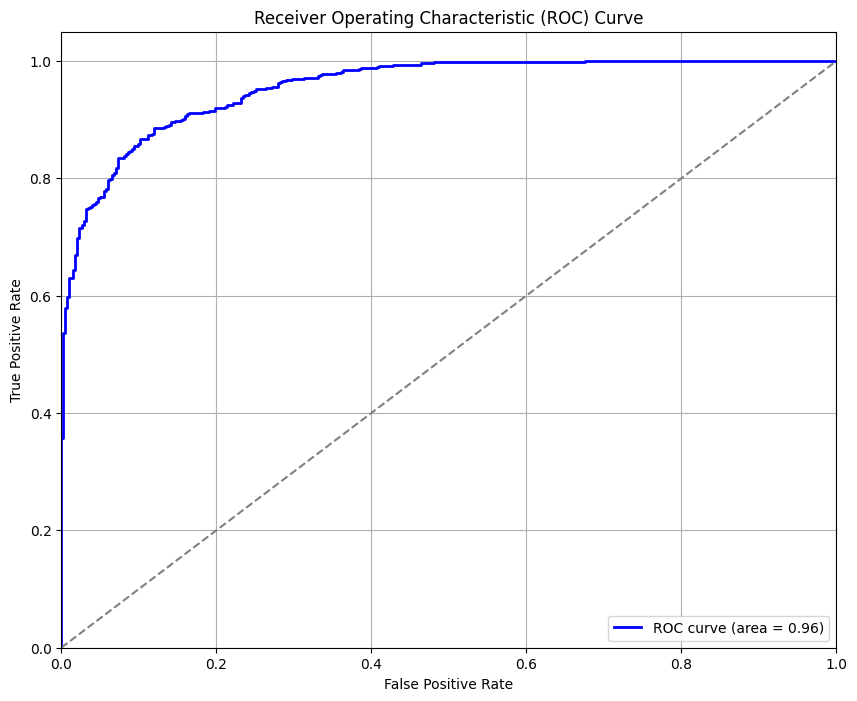

ROC AUC Score: 0.96


In [ ]:
# Calculate ROC curve and AUC
from sklearn.metrics import roc_curve, roc_auc_score

# Assuming you have y_true (true labels) and y_pred (predicted probabilities)
# Replace with your actual variable names if different
y_true = test_generator.labels
y_pred_probs = model.predict(test_generator)

fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
roc_auc = roc_auc_score(y_true, y_pred_probs)

# Now you can plot the ROC curve
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid()
plt.show()
print(f'ROC AUC Score: {roc_auc:.2f}')

In [ ]:
# Evaluate the model
test_loss, test_accuracy, test_auc = model.evaluate(test_generator, verbose=1)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test AUC: {test_auc:.4f}")

28/28 ━━━━━━━━━━━━━━━━━━━━ 217s 8s/step - accuracy: 0.8451 - auc: 0.5910 - loss: 0.2802
Test Loss: 0.2792
Test Accuracy: 86.38%
Test AUC: 0.9557


In [ ]:
# Generate predictions
y_pred = model.predict(test_generator)
y_pred_classes = np.where(y_pred > 0.5, 1, 0)
y_test = test_generator.labels


28/28 ━━━━━━━━━━━━━━━━━━━━ 156s 6s/step


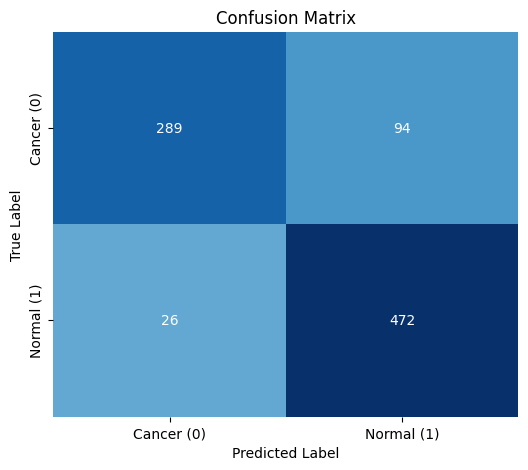

Classification Report:
               precision    recall  f1-score   support

  Cancer (0)       0.92      0.75      0.83       383
  Normal (1)       0.83      0.95      0.89       498

    accuracy                           0.86       881
   macro avg       0.88      0.85      0.86       881
weighted avg       0.87      0.86      0.86       881



In [ ]:
# Confusion Matrix
CM = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(CM, fmt='g', center=True, cbar=False, annot=True, cmap='Blues',
            xticklabels=['Cancer (0)', 'Normal (1)'],
            yticklabels=['Cancer (0)', 'Normal (1)'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:\n', classification_report(y_test, y_pred_classes, target_names=['Cancer (0)', 'Normal (1)']))
